In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
import torch

# VAE kernels
Can we use VAE as a kernel for convolutional layer? The idea is that for each receptive field, VAE would find multinomial gaussian distribution shared across all instances of the receptive field. The resulting system would have features, feature value ranges and distributions at each receptive field, similar to neurons with various feature value preferences for each receptive field in the cortex. For example, a neuron may have a preference for horizontal lines, upward movement, slow speed movement. That would be equivalent to VAE finding 3 features with specific values for a given receptive field. A neuron can have preference for only one (or few) values of a given feature so a lot of neurons are needed to represent the domain of each feature with sufficient statistical redundency. But a VAE's output for a given receptive field, e.g. 0.3 for feature 1, 0.9 for feature 2 and 0.5 for feature 3 with low, high and medium variance, respectively, can represent 1000s of feature-value preferences and 100s of neurons (because a neuron can be selective to a different value for each feature). The similifying factor here is Laplace assumption. Maybe using an order of magnitude more # of features would result at least in mixture of gaussians because a feature would get duplicated and learn different modes of the distribution.

## Basics

In [0]:
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def generate_bouncing_pixel(width, height, count=100):
  ball_width = 2
  x = 3 #random.randint(0, width)
  y = 2 #random.randint(0, height)
  dx = -1 #random.randint(0, 2) - 1
  dy = 1 #random.randint(0, 2) - 1
  
  images = []
  for _ in range(count):
    image = np.zeros((width, height))
    image[x, y] = 1.0
    image[x+1, y] = 1.0
    image[x, y+1] = 1.0
    image[x+1, y+1] = 1.0

    #image=gaussian_filter(image, 0.5)
    images.append(image)
    x += dx
    y += dy
    if (x < 0 or x > width - 1 - (ball_width - 1)):
      dx *= -1
      x += dx
    if (y < 0 or y > height - 1 - (ball_width - 1)):
      dy *= -1
      y += dy

  return torch.as_tensor(images)

def convolve(image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = []
  for x in range(0, image_width - kernel_width + 1, stride):
    for y in range(0, image_height - kernel_height + 1, stride):
      convolutions.append([y, x, y + kernel_height, x + kernel_width])

  return convolutions

def conv_slice(images, image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(image_count) for c in convolutions]

  slices = torch.stack(slices).float()
  slices = slices.view(slices.shape[0], -1).to(device)
  return slices


def conv_join(slices, image_count, image_width, image_height, kernel_width, kernel_height, stride):
  print("slices.shape", slices.shape)
  if len(slices.shape) == 2:
    slices = slices.view(image_count, int(slices.shape[0] / image_count), kernel_width, kernel_height)

  # slices is now (image count, convolutions, kernel size, kernel size)
  #print("slices.shape", slices.shape)

  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  assert len(convolutions) == slices.shape[1]

  buffer = torch.zeros((image_count, image_width, image_height)).to(device)
  #print("buffer", buffer.shape)

  for i in range(image_count):
    #if i == 0:
    #  print("slices[i]", slices[i])

    for x in range(image_width):
      for y in range(image_height):
        values = []
        for c in range(len(convolutions)):
          convolution = convolutions[c]
          if x >= convolution[0] and x < convolution[2] and y >= convolution[1] and y < convolution[3]:
            value = slices[i, c, x - convolution[0], y - convolution[1]]
            values.append(value.item())
            #if i == 0 and x == 3 and y == 3:
            #  print(f"x {x}, y {y}, convolution {convolution}")
            #  print(f"[{x - convolution[0]}, {y - convolution[1]}]", value)

        #if i == 0 and x == 3 and y == 3:
        #  print(f"i {i}, x {x}, y {y}")
        #  print("values", values)
        if len(values) > 0:
          value = np.average(values)
          #print("value", value)
          buffer[i, x, y] = value

  return buffer


## Network


In [0]:
class VAE(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(VAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.feature_count = feature_count

    self.encoder = nn.Sequential(
      nn.Linear(input_width * input_height    , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height * 4),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
    )

#     self.e_l1 = nn.Linear(input_width * input_height    , input_width * input_height * 2)
#     self.e_b1 = nn.BatchNorm1d(1)
#     self.e_r1 = nn.LeakyReLU(0.2, inplace=True)
#     self.e_l2 = nn.Linear(input_width * input_height * 2, input_width * input_height * 4)
#     self.e_b2 = nn.BatchNorm1d(1)
#     self.e_r2 = nn.LeakyReLU(0.2, inplace=True)
      
    self.decoder = nn.Sequential(
      nn.Linear(feature_count  , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height),
      #nn.BatchNorm2d(1),
      nn.Sigmoid(),
    )

    self.linear_mu = nn.Linear(input_width * input_height * 4, feature_count)
    self.linear_sigma = nn.Linear(input_width * input_height * 4, feature_count)

    self.lrelu = nn.LeakyReLU()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

  def encode(self, x):
    self.logger.debug(f"x {x.shape}")
    x = self.encoder(x)
#     x = self.e_l1(x)
#     #x = self.e_b1(x)
#     x = self.e_r1(x)
#     x = self.e_l2(x)
#     #x = self.e_b2(x)
#     x = self.e_r2(x)
    
    #return self.tanh(self.linear_mu(x)), self.tanh(self.linear_sigma(x))
    return self.sigmoid(self.linear_mu(x)), self.linear_sigma(x)

  def decode(self, z):
    #z = z.view(-1, 1, 1, self.feature_count)
    self.logger.debug(f"z {z.shape}")
    return self.decoder(z)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_().to(device)
    eps = eps.mul(std).add_(mu)
    eps = torch.sigmoid(eps)
    self.logger.debug(f"eps {eps.shape}")

    return eps

  def decode_features(self, mu, logvar):
    z = self.reparametrize(mu, logvar)
    self.logger.debug(f"z {z.shape}")
    decoded = self.decode(z)
    self.logger.debug(f"decoded {decoded.shape}")
    return decoded, z

    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    mu, logvar = self.encode(x)
    self.logger.debug(f"mu {mu.shape}")
    self.logger.debug(f"logvar {logvar.shape}")
    
    decoded, z = self.decode_features(mu, logvar)
    return decoded, mu, logvar, z
  
  
class Network(nn.Module):
  def __init__(self, image_width, image_height, kernel_width, kernel_height, stride, feature_count):
    super(Network, self).__init__()
    self.image_width = image_width
    self.image_height = image_height
    self.kernel_width = kernel_width
    self.kernel_height = kernel_height
    self.feature_count = feature_count
    self.stride = stride

    self.vae = VAE(kernel_width, kernel_height, feature_count)
    self.trained = False
    
    if os.path.exists(self.save_path()):
      self.load_state_dict(torch.load(self.save_path()))
      self.eval()
      self.trained = True

  def forward(self, x):
    return self.vae(x)

  def loss_function(self, recon_x, x, mu, logvar):
    # print(recon_x.size(), x.size())
    BCE = F.binary_cross_entropy(recon_x.view(-1, self.kernel_width * self.kernel_height), x.view(-1, self.kernel_width * self.kernel_height), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    BCE /= 0.00001
    #print(BCE, KLD)
    return BCE + KLD

  def train(self, images, num_epochs=3000):
    if self.trained:
      return
    
    if isinstance(images, bool):
      return

    print("images", images.shape)


    input = conv_slice(images, self.image_width, self.image_height, self.kernel_width, self.kernel_height, self.stride)
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)

    done = False
    dataset = torch.utils.data.TensorDataset(input)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

    epoch = 0
    while not done:
      for i, batch in enumerate(data_loader):
        batch = batch[0].to(device)
        output, mu, logvar, z = self(batch)
        loss = self.loss_function(output, batch, mu, logvar)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if epoch % int(num_epochs / 10) == 0:
        output, mu, logvar, z = self(input[0].unsqueeze(dim=0))
        print('epoch [{}/{}], loss:{:.4f}'
             .format(epoch+1, num_epochs, loss.item()))
        show_image(output[0].view(self.kernel_height, self.kernel_width).detach(), title=f"output {0}", vmin=0, vmax=1)

      if (loss.item() < 0.001 and epoch > 1500) or epoch > num_epochs:
        done = True

      epoch += 1

    torch.save(self.state_dict(), self.save_path())

  def eval_data(self, images):
    input = conv_slice(images, self.image_width, self.image_height, self.kernel_width, self.kernel_height, self.stride)

    reconstructed_slices, mu, logvar, z = self(input)
    #reconstructed_slices = output[0]
    reconstructed_images = conv_join(reconstructed_slices, images.shape[0], self.image_width, self.image_height, self.kernel_width, self.kernel_height, self.stride)
    return reconstructed_images, reconstructed_slices, mu, logvar, z
    
  def save_path(self):
    return f"network.pt"




## Example

images torch.Size([20, 16, 16])
epoch [1/4000], loss:92148160.0000


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


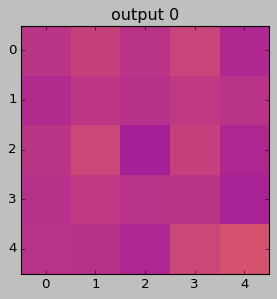

epoch [401/4000], loss:3087580.5000


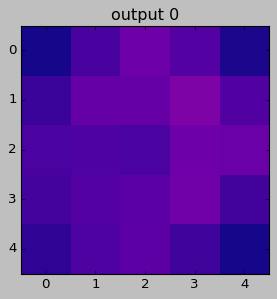

epoch [801/4000], loss:2205381.7500


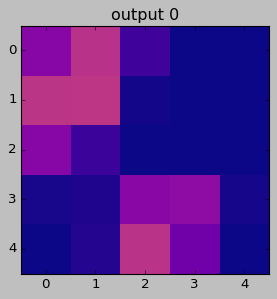

epoch [1201/4000], loss:681196.0000


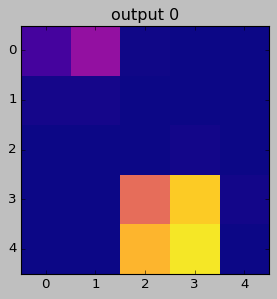

epoch [1601/4000], loss:90483.4844


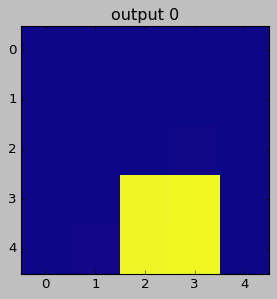

epoch [2001/4000], loss:10123.3369


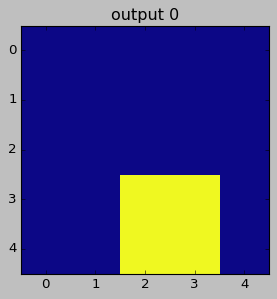

epoch [2401/4000], loss:3784.8203


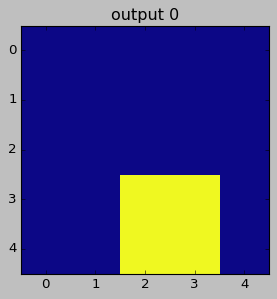

epoch [2801/4000], loss:1565.6538


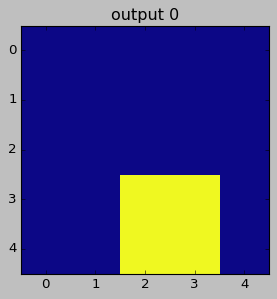

epoch [3201/4000], loss:1012.8928


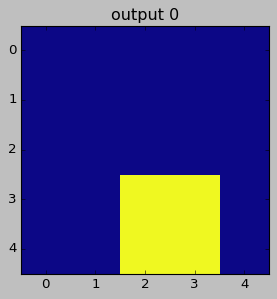

epoch [3601/4000], loss:1091.7587


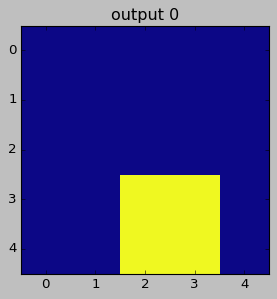

epoch [4001/4000], loss:1175.8286


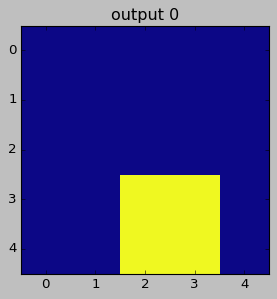

slices.shape torch.Size([2880, 25])
------------------------- IMAGE 0 --------------------------


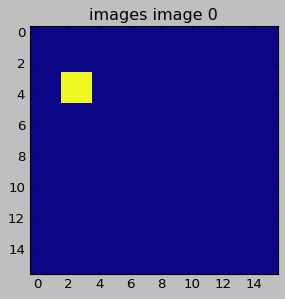

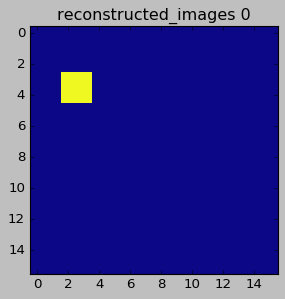

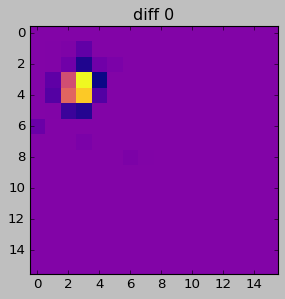

------------------------- IMAGE 1 --------------------------


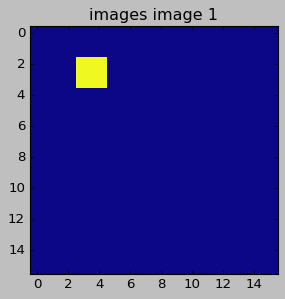

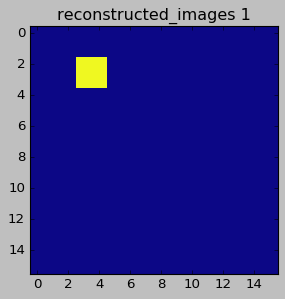

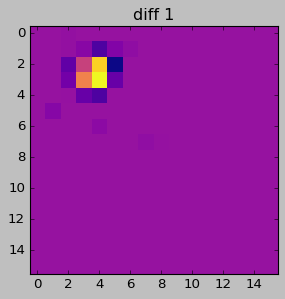

------------------------- IMAGE 2 --------------------------


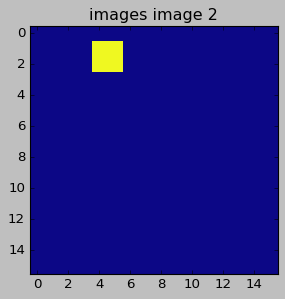

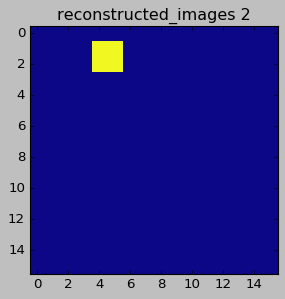

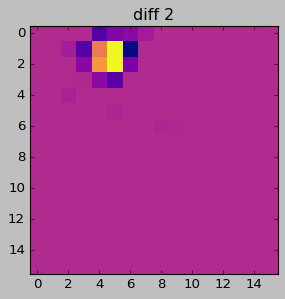

------------------------- IMAGE 3 --------------------------


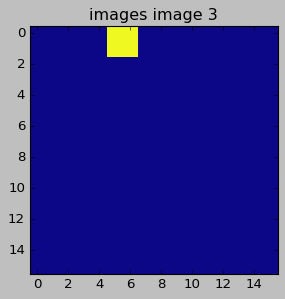

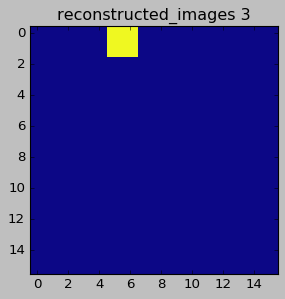

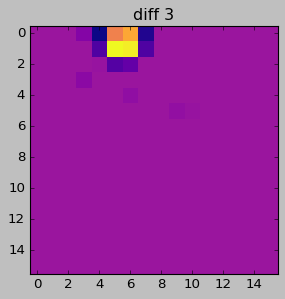

------------------------- IMAGE 4 --------------------------


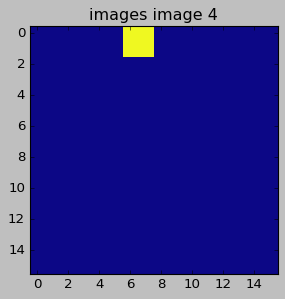

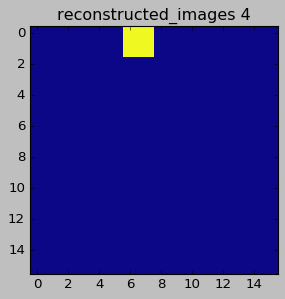

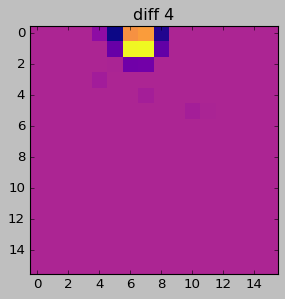

------------------------- IMAGE 5 --------------------------


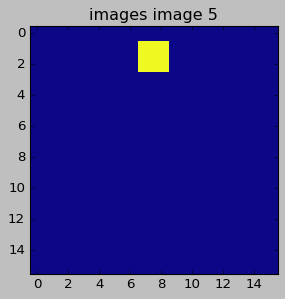

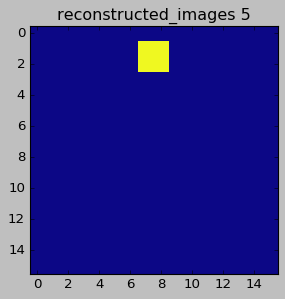

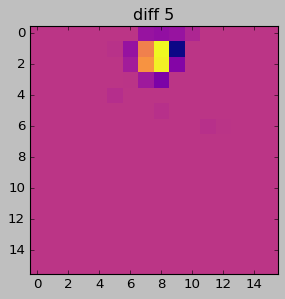

------------------------- IMAGE 6 --------------------------


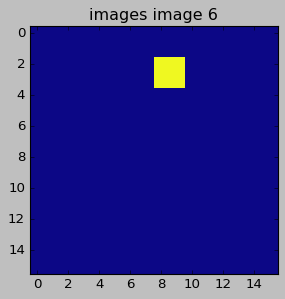

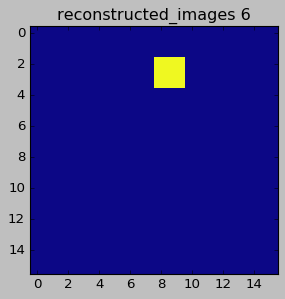

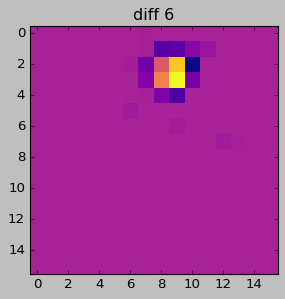

------------------------- IMAGE 7 --------------------------


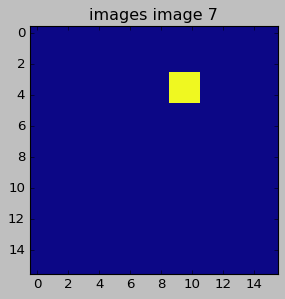

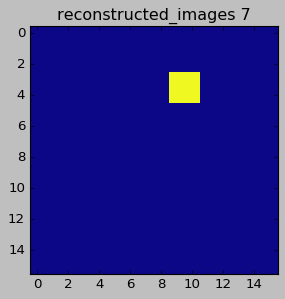

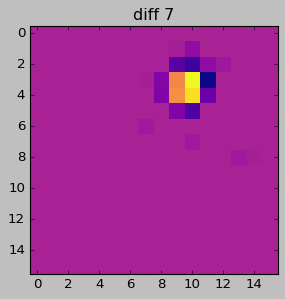

------------------------- IMAGE 8 --------------------------


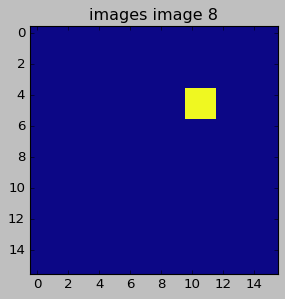

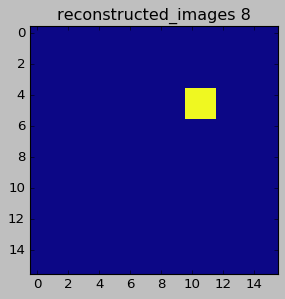

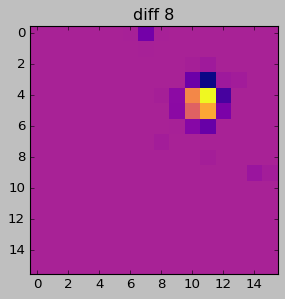

------------------------- IMAGE 9 --------------------------


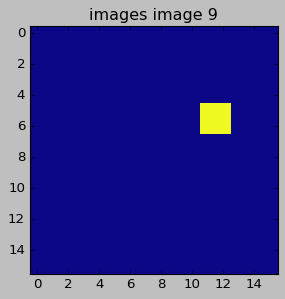

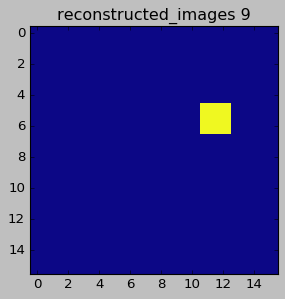

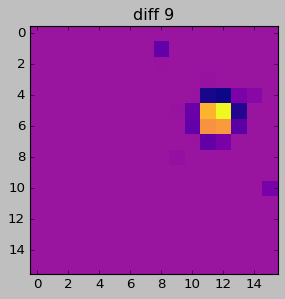

------------------------- IMAGE 10 --------------------------


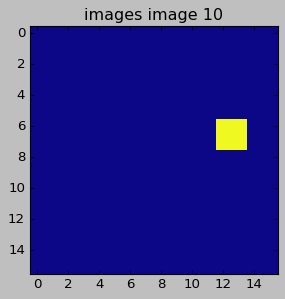

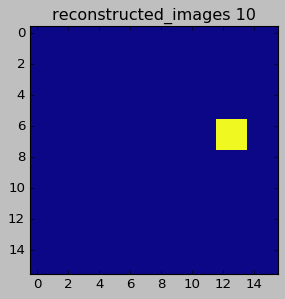

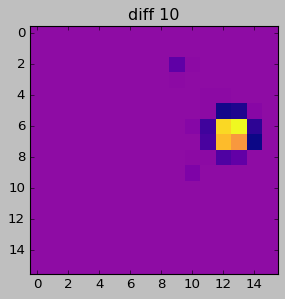

------------------------- IMAGE 11 --------------------------


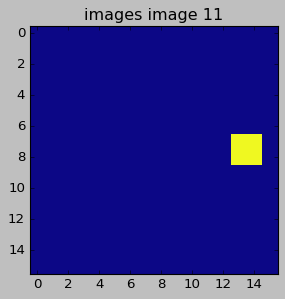

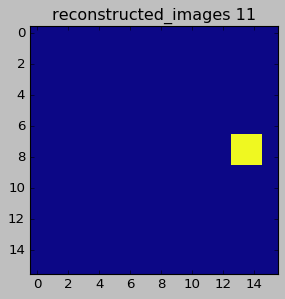

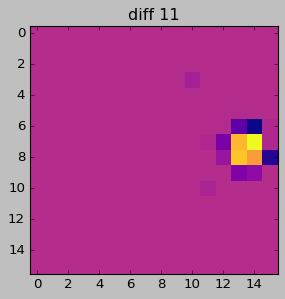

------------------------- IMAGE 12 --------------------------


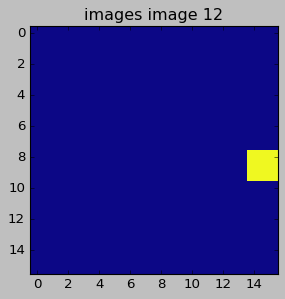

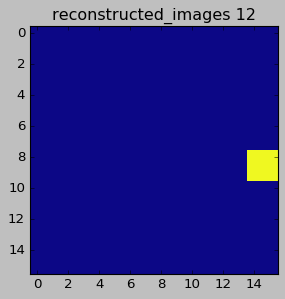

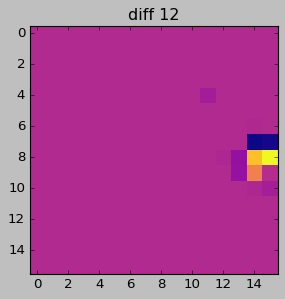

------------------------- IMAGE 13 --------------------------


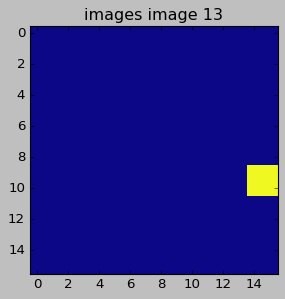

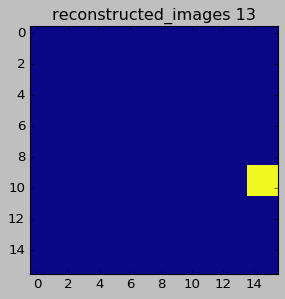

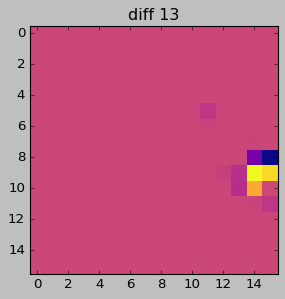

------------------------- IMAGE 14 --------------------------


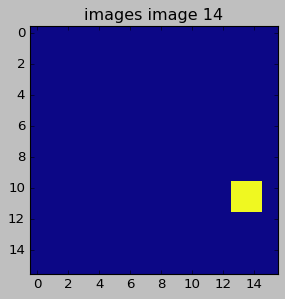

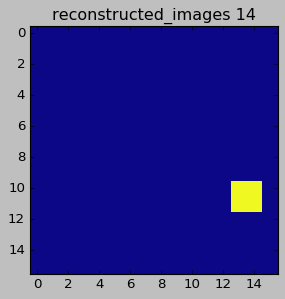

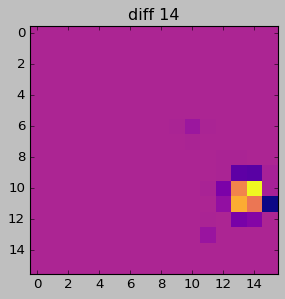

------------------------- IMAGE 15 --------------------------


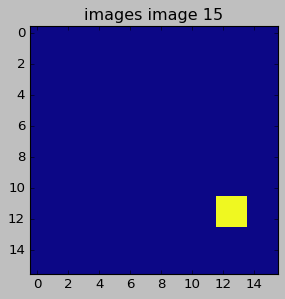

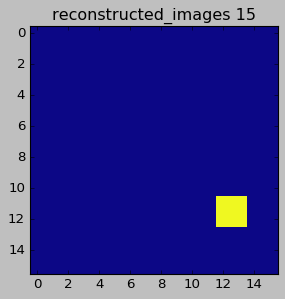

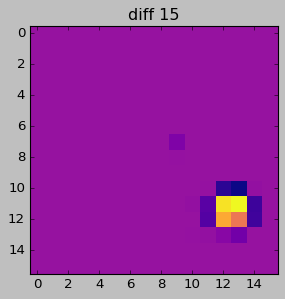

------------------------- IMAGE 16 --------------------------


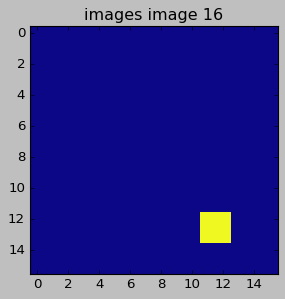

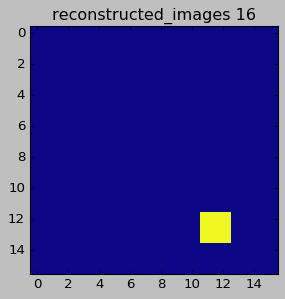

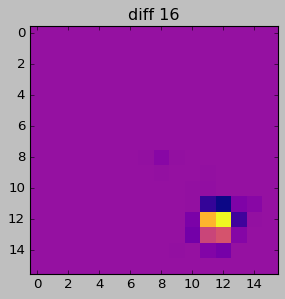

------------------------- IMAGE 17 --------------------------


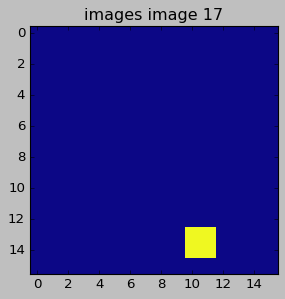

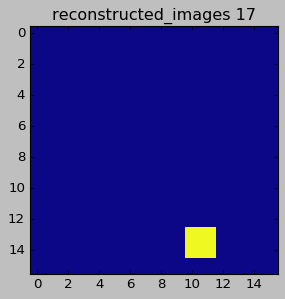

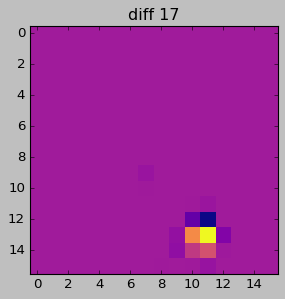

------------------------- IMAGE 18 --------------------------


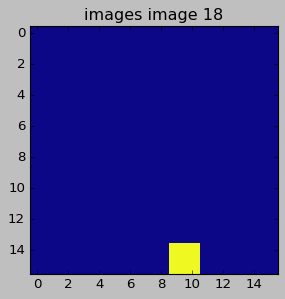

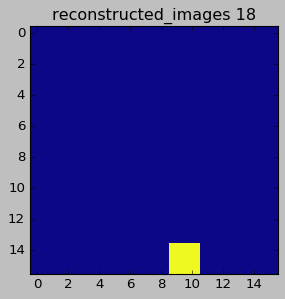

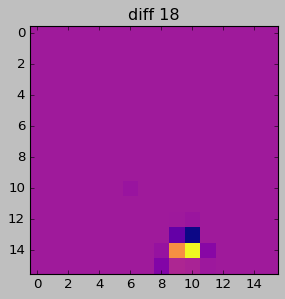

------------------------- IMAGE 19 --------------------------


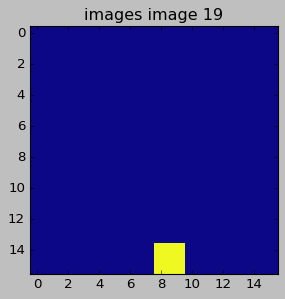

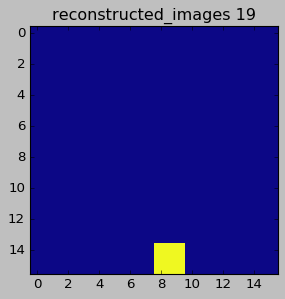

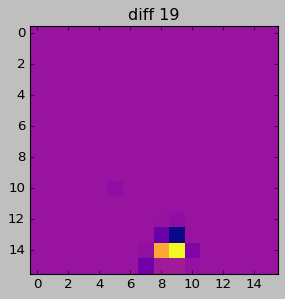

In [4]:
if False:
  import os
  import glob

  files = glob.glob('./*.pt')
  for f in files:
      os.remove(f)

image_height = image_width = image_size = 16
image_count = 20
kernel_size = 5
stride = 1
feature_count = 4

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

images = generate_bouncing_pixel(image_height, image_width, count=image_count)

network = Network(image_width=image_width, image_height=image_height, kernel_width=kernel_size, kernel_height=kernel_size, stride=stride, feature_count=feature_count).to(device)
network.train(images, num_epochs=4000)
reconstructed_images, reconstructed_slices, mu, logvar, z = network.eval_data(images)



for i in range(20):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(images[i].detach(), vmin=0, vmax=1, title=f"images image {i}")
  show_image(reconstructed_images[i].detach(), vmin=0, vmax=1, title=f"reconstructed_images {i}")
  show_image(images[i].float()-reconstructed_images[i].detach().cpu(), title=f"diff {i}")



mu torch.Size([7200, 4])
input_size 7200
mu.shape torch.Size([7200, 4])
a 2
a 2


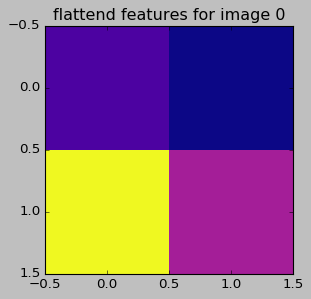

unflatten 1:  torch.Size([7200, 2, 2])
unflatten 2:  torch.Size([7200, 1, 2, 1, 2])
unflatten 3:  torch.Size([7200, 1, 1, 2, 2])
unflatten 4:  torch.Size([7200, 4])


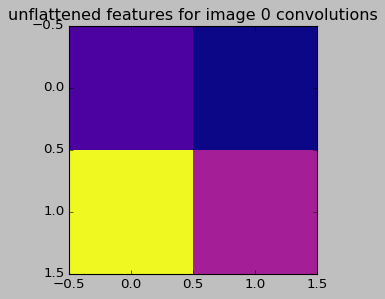

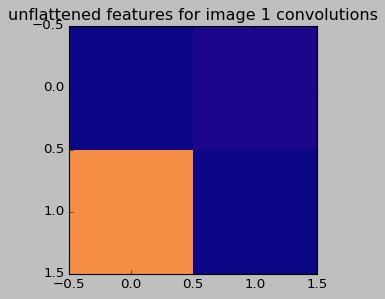

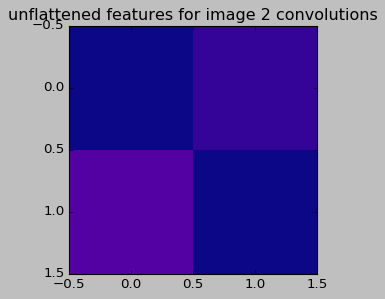

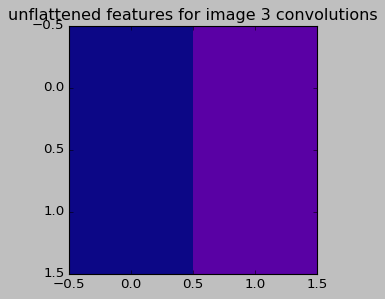

decoded torch.Size([7200, 25])


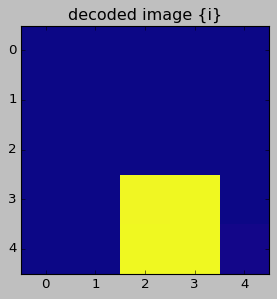

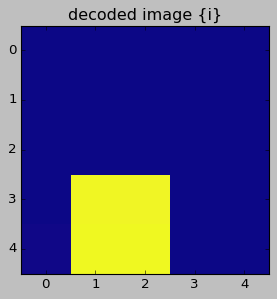

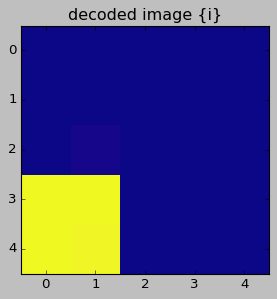

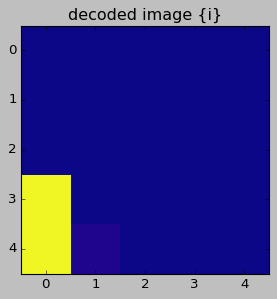

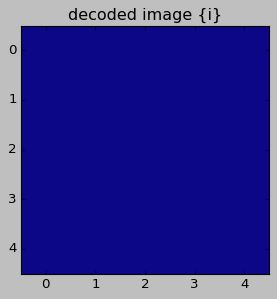

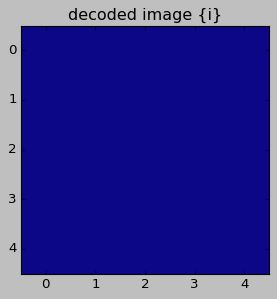

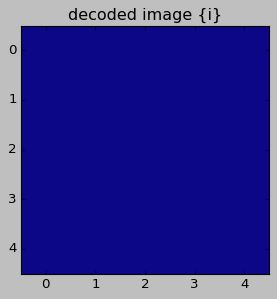

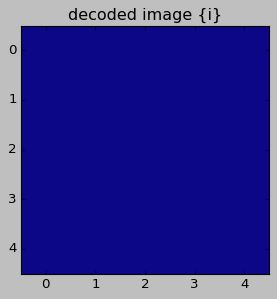

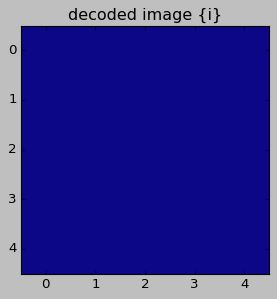

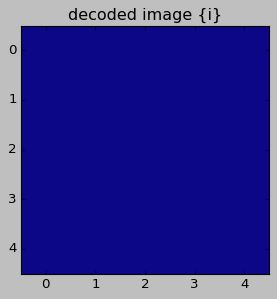

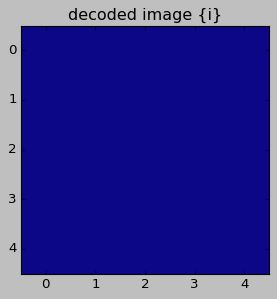

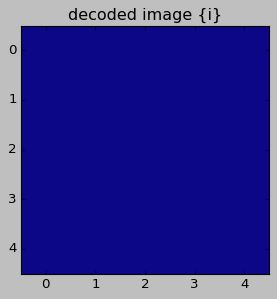

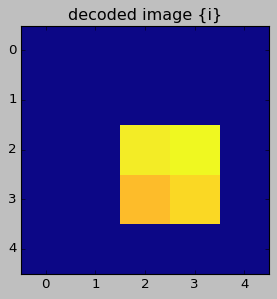

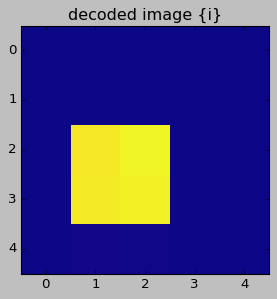

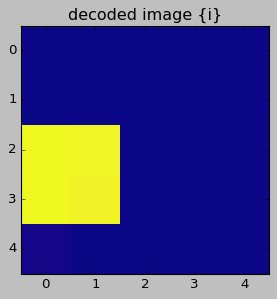

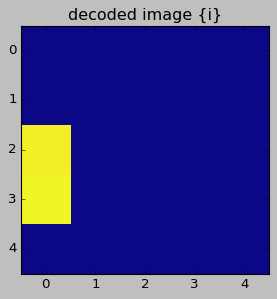

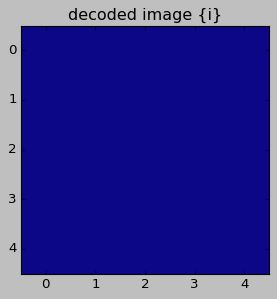

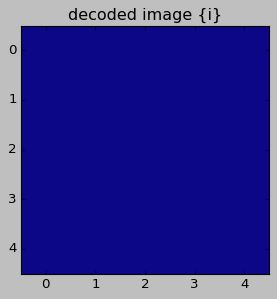

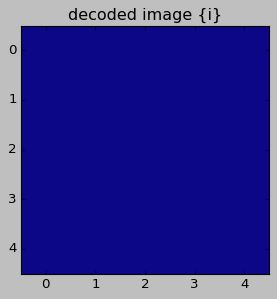

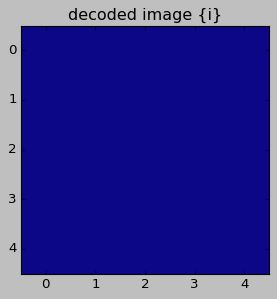

In [23]:
# decoded, mu, logvar, z = network.train(input, num_epochs=100)

# print(mu.shape)
# print(mu)
# print("------------")

# for i in range(4):
#   show_image(mu[i].detach().view(2, 2), vmin=0, vmax=1, title=f"features for image 0 convolutions")

def flatten_features(mu, input_size):
  a = int(mu.shape[1] ** 0.5)
  print("mu.shape", mu.shape)
  print("a", a)
  w = int(int(mu.shape[0] / input_size) ** 0.5)
  mu1 = mu.view(input_size, w, w, a , a)
  mu1 = mu1.permute(0, 1, 3, 2, 4)
  s = mu1.shape
  mu1 = mu1.contiguous().view(s[0], s[1] * s[2], s[3] * s[4])
  return mu1, a

def unflatten_features(h1, a):
  s = h1.shape
  print("unflatten 1: ", s)
  h = h1.view(s[0], int(s[1] / a), a, int(s[2] / a), a)
  print("unflatten 2: ", h.shape)
  h = h.permute(0, 1, 3, 2, 4)
  print("unflatten 3: ", h.shape)
  
  s = h.shape
  h = h.contiguous().view(s[0] * s[1] * s[2], s[3] * s[4])
  print("unflatten 4: ", h.shape)

  return h

def decode(unflattened_mu, logvar, network):
  return network.vae.decode_features(unflattened_mu, logvar)
  
print("mu", mu.shape)
print("input_size", input_size)
h1, a = flatten_features(mu, input_size)
print("a", a)
# print(mu)
# print("------------")
for i in range(1):
  show_image(h1[i].detach(), vmin=0, vmax=1, title=f"flattend features for image {i}")

unflattened_mu = unflatten_features(h1, a)
for i in range(4):
  show_image(unflattened_mu[i].detach().view(2, 2), vmin=0, vmax=1, title=f"unflattened features for image {i} convolutions")

decoded, _ = decode(unflattened_mu, torch.ones(unflattened_mu.size()).mul(-10).to(device), network)
print("decoded", decoded.shape)

for i in range(20):
  show_image(decoded[i].detach().view(kernel_size, kernel_size), vmin=0, vmax=1, title="decoded image {i}")
  
  
# print(logvar.exp())
# print(z)
# decoded = network.vae.decode(torch.as_tensor(z[6:7,:]).to(device))
# show_image(decoded[0].detach().view(input_height, input_width), vmin=0, vmax=1)



# TODO!!!
# h1 flattended feature map (image count, conv stpes * features, conv steps * features) ==> unflattened

------------------------- IMAGE 0 --------------------------


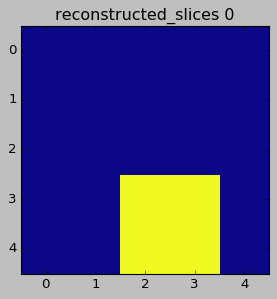

------------------------- IMAGE 1 --------------------------


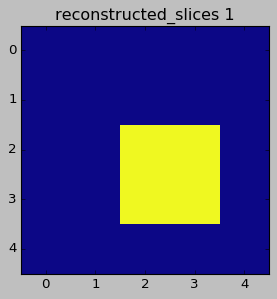

------------------------- IMAGE 2 --------------------------


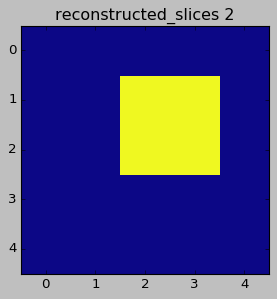

------------------------- IMAGE 3 --------------------------


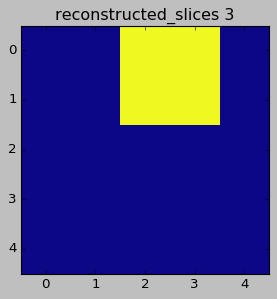

------------------------- IMAGE 4 --------------------------


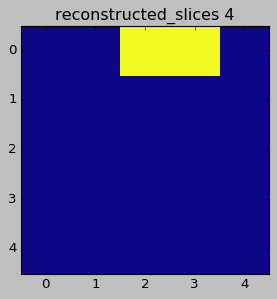

------------------------- IMAGE 5 --------------------------


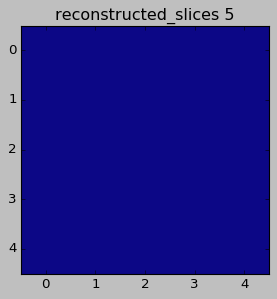

------------------------- IMAGE 6 --------------------------


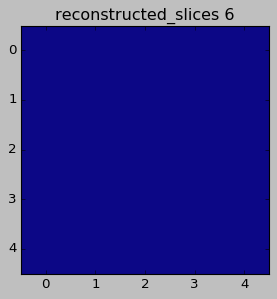

------------------------- IMAGE 7 --------------------------


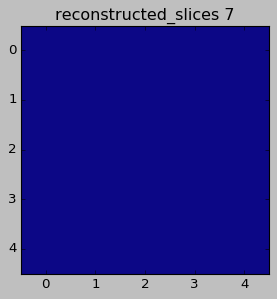

------------------------- IMAGE 8 --------------------------


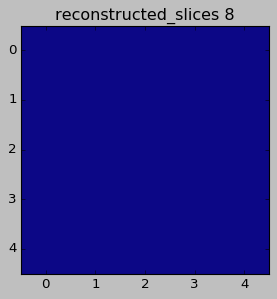

------------------------- IMAGE 9 --------------------------


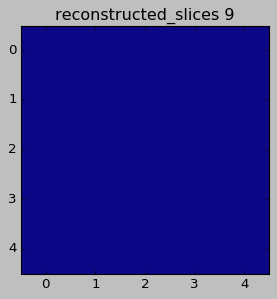

------------------------- IMAGE 10 --------------------------


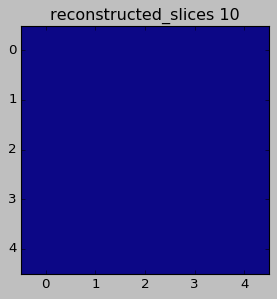

------------------------- IMAGE 11 --------------------------


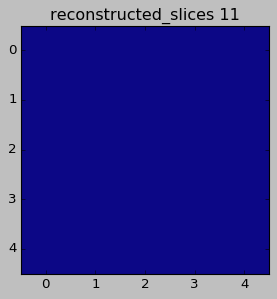

------------------------- IMAGE 12 --------------------------


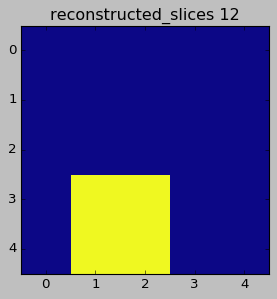

------------------------- IMAGE 13 --------------------------


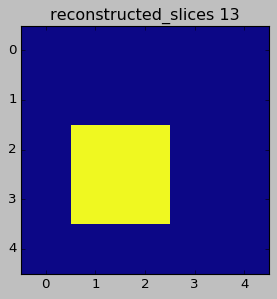

------------------------- IMAGE 14 --------------------------


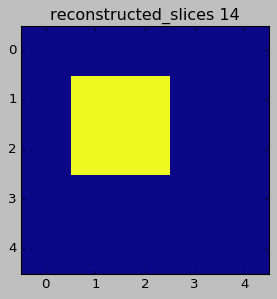

------------------------- IMAGE 15 --------------------------


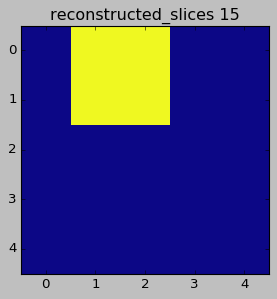

------------------------- IMAGE 16 --------------------------


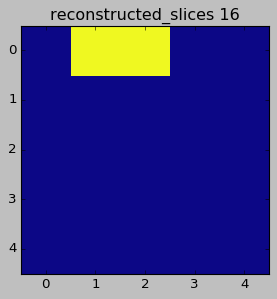

------------------------- IMAGE 17 --------------------------


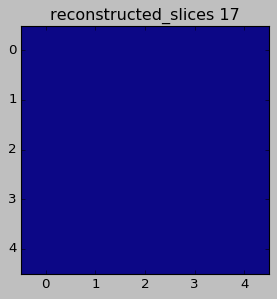

------------------------- IMAGE 18 --------------------------


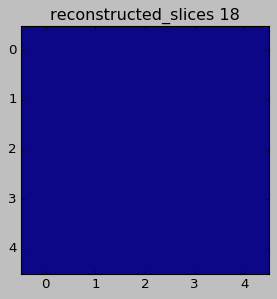

------------------------- IMAGE 19 --------------------------


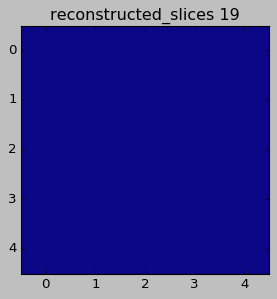

In [104]:
for i in range(20):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(reconstructed_slices[i].detach().view(kernel_size, kernel_size), vmin=0, vmax=1, title=f"reconstructed_slices {i}")



In [8]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [30]:
torch.zeros((3,2))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])